# Atividade Computacional 2

## Aluno: Dylan Faria Robson

## Import

In [1]:
#Para ter reprodutibilidade - Rodar esse celula e reiniciar o Kernel para ter efeito!
import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
# --- Importações Essenciais ---
import numpy as np
import random
import time
import warnings
import pandas as pd
from deap import base, creator, tools, algorithms

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_openml

# Visualização
import matplotlib.pyplot as plt
# Para exibição de tabelas estilizadas no Jupyter
from IPython.display import display

# --- Configurações Globais ---
warnings.filterwarnings('ignore', category=UserWarning) # Ignorar avisos de convergência do MLP

## Funções

In [3]:
#Reprodutibilidade
random.seed(SEED)
np.random.seed(SEED)

In [4]:
# --- Carregamento do Dataset MNIST ---
print("Carregando o dataset MNIST...")
# Usamos fetch_openml para obter o dataset completo de 70.000 imagens
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
print("Dataset carregado.")

# X são as imagens (features), y são os rótulos (labels)
X = mnist.data
y = mnist.target.astype(int)

# --- Pré-processamento ---
# 1. Normalização: Escala os pixels para o intervalo 
X_normalized = X / 255.0

# 2. Divisão em Treino e Teste (usando a semente para consistência)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=SEED, stratify=y
)

# 3. Criação de um Subconjunto para Avaliação Rápida da Fitness
# Esta é uma prática comum para acelerar a otimização evolutiva
SUBSET_SIZE = 0.1 # 10% dos dados de treino para a avaliação de fitness
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, train_size=SUBSET_SIZE, random_state=SEED, stratify=y_train
)

print(f"\nDimensões dos dados:")
print(f"  - Treino Completo: {X_train.shape}")
print(f"  - Teste Completo:  {X_test.shape}")
print(f"  - Subconjunto de Treino (para fitness): {X_train_sub.shape}")

Carregando o dataset MNIST...
Dataset carregado.

Dimensões dos dados:
  - Treino Completo: (56000, 784)
  - Teste Completo:  (14000, 784)
  - Subconjunto de Treino (para fitness): (5600, 784)


In [5]:
 #--- Componentes do Modelo (Scikit-learn) ---

# Classe para extrair features do encoder do autoencoder
# Esta classe é uma solução engenhosa para contornar a limitação do MLPRegressor,
# que não expõe diretamente as ativações das camadas intermediárias.
class EncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, encoder_weights, encoder_biases):
        self.encoder_weights = encoder_weights
        self.encoder_biases = encoder_biases

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoded_X = X
        # Aplicar cada camada do encoder manualmente
        for weights, biases in zip(self.encoder_weights, self.encoder_biases):
            encoded_X = np.dot(encoded_X, weights) + biases
            # Usar a mesma função de ativação do MLPRegressor (ReLU)
            encoded_X = np.maximum(0, encoded_X)
        return encoded_X

In [6]:
# Criação de um subconjunto para avaliação rápida e robusta da fitness
SUBSET_SIZE = 0.1
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, train_size=SUBSET_SIZE, random_state=SEED, stratify=y_train
)

# Dividir o subconjunto em treino e validação para a fitness
X_fit_train, X_fit_val, y_fit_train, y_fit_val = train_test_split(
    X_train_sub, y_train_sub, test_size=0.3, random_state=SEED, stratify=y_train_sub
)

# --- Classe Helper (Já existente no seu código) ---
class EncoderTransformer(BaseEstimator, TransformerMixin):
    # ... (código da classe) ...
    def __init__(self, encoder_weights, encoder_biases):
        self.encoder_weights = encoder_weights
        self.encoder_biases = encoder_biases
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        encoded_X = X
        for weights, biases in zip(self.encoder_weights, self.encoder_biases):
            encoded_X = np.maximum(0, np.dot(encoded_X, weights) + biases)
        return encoded_X

# --- 1. DEFINIÇÃO DA FUNÇÃO DE FITNESS (MOVIDA PARA CIMA) ---
# Esta função precisa ser definida ANTES da toolbox que irá registrá-la.

def evaluate_robust(individual):
    """
    Função de fitness robusta. Treina o modelo em uma parte do subconjunto
    e avalia em outra (validação), para evitar sobreajuste.
    """
    try:
        learning_rate = individual[-1]
        hidden_layers = tuple(int(n) for n in individual[:-1] if n > 0)

        if not hidden_layers:
            return (0.0,)

        encoder_layers = hidden_layers
        decoder_layers = hidden_layers[::-1]
        autoencoder_arch = encoder_layers + decoder_layers

        autoencoder = MLPRegressor(
            hidden_layer_sizes=autoencoder_arch,
            activation='relu', solver='adam',
            learning_rate_init=learning_rate,
            max_iter=50, random_state=SEED, tol=1e-3
        )
        classifier = LogisticRegression(
            solver='saga', max_iter=100, random_state=SEED
        )
        
        # Treinar o autoencoder
        autoencoder.fit(X_fit_train, X_fit_train)

        # Criar o pipeline para extração de features e classificação
        num_encoder_layers = len(encoder_layers)
        encoder_transformer = EncoderTransformer(
            autoencoder.coefs_[:num_encoder_layers],
            autoencoder.intercepts_[:num_encoder_layers]
        )
        pipeline = Pipeline([
            ('encoder', encoder_transformer),
            ('classifier', classifier)
        ])

        # Treinar o classificador
        pipeline.fit(X_fit_train, y_fit_train)

        # Avaliar a acurácia no conjunto de VALIDAÇÃO
        y_pred = pipeline.predict(X_fit_val)
        accuracy = accuracy_score(y_fit_val, y_pred)
        
        return (accuracy,)

    except Exception as e:
        return (0.0,)


In [7]:
# --- Configuração do DEAP ---

# 1. Definir o tipo de fitness e o indivíduo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Inicializar a Toolbox
toolbox = base.Toolbox()

# --- Definição dos Genes (Hiperparâmetros) ---
# Gene para o número de neurônios: inteiro entre 16 e 256
toolbox.register("attr_neuron", random.randint, 16, 256)
# Gene para a taxa de aprendizado: float entre 0.0001 e 0.1
toolbox.register("attr_lr", random.uniform, 0.0001, 0.1)

# --- Definição do Indivíduo ---
# Otimizaremos até 3 camadas ocultas no encoder
# Formato do indivíduo: [n_camada1, n_camada2, n_camada3, taxa_aprendizado]
# Um valor 0 em n_camadaX significa que a camada não será usada
def create_individual():
    neurons = [toolbox.attr_neuron() for _ in range(3)]
    # Adiciona uma chance de ter menos camadas (define neurônios como 0)
    num_layers = random.randint(1, 3)
    for i in range(3 - num_layers):
        neurons[random.randint(0, len(neurons)-1)] = 0
    
    # Garante que pelo menos uma camada tenha neurônios
    if all(n == 0 for n in neurons):
        neurons[0] = toolbox.attr_neuron()
        
    individual = neurons + [toolbox.attr_lr()]
    return creator.Individual(individual)

def mutate_individual(individual, indpb=0.2):
    # Mutar neurônios (inteiro)
    for i in range(len(individual) - 1):
        if random.random() < indpb:
            individual[i] = max(0, individual[i] + random.randint(-20, 20))
            
    # Mutar taxa de aprendizado (float)
    if random.random() < indpb:
        individual[-1] += random.gauss(0, 0.005)
        individual[-1] = max(0.0001, min(individual[-1], 0.1))
        
    return individual,
print("Toolbox do DEAP configurada para ES.")

Toolbox do DEAP configurada para ES.


In [8]:
# --- Função de Fitness Robusta ---
# Esta é a correção mais importante. A função agora divide o subconjunto de fitness
# em treino e validação para obter uma estimativa mais realista da generalização.
def evaluate_robust(individual):
    """
    Função de fitness que treina um autoencoder e um classificador,
    usando uma divisão interna de treino/validação para uma avaliação mais robusta.
    Retorna a acurácia de validação.
    """
    try:
        # 1. Decodificar o indivíduo
        learning_rate = individual[-1]
        # Camadas com 0 neurônios são ignoradas, permitindo arquiteturas de profundidade variável
        hidden_layers = tuple(int(n) for n in individual[:-1] if n > 0)

        if not hidden_layers:
            return (0.0,)

        # 2. Criar uma divisão interna para validação da fitness
        # Isto evita que a fitness seja calculada nos mesmos dados do treino.
        X_fit_train, X_fit_val, y_fit_train, y_fit_val = train_test_split(
            X_train_sub, y_train_sub, test_size=0.3, random_state=SEED, stratify=y_train_sub
        )

        # 3. Construir a arquitetura do Autoencoder (simétrica)
        encoder_layers = hidden_layers
        decoder_layers = hidden_layers[::-1]
        autoencoder_arch = encoder_layers + decoder_layers

        # 4. Instanciar os modelos
        autoencoder = MLPRegressor(
            hidden_layer_sizes=autoencoder_arch,
            activation='relu',
            solver='adam',
            learning_rate_init=learning_rate,
            max_iter=50, # Iterações limitadas para avaliação rápida
            random_state=SEED,
            tol=1e-3
        )
        classifier = LogisticRegression(
            solver='saga', max_iter=100, random_state=SEED
        )
        
        # 5. Treinar o Autoencoder no conjunto de treino da fitness (X_fit_train)
        autoencoder.fit(X_fit_train, X_fit_train)

        # 6. Extrair o Encoder e criar o pipeline
        num_encoder_layers = len(encoder_layers)
        encoder_weights = autoencoder.coefs_[:num_encoder_layers]
        encoder_biases = autoencoder.intercepts_[:num_encoder_layers]
        encoder_transformer = EncoderTransformer(encoder_weights, encoder_biases)

        pipeline = Pipeline([
            ('encoder', encoder_transformer),
            ('classifier', classifier)
        ])

        # 7. Treinar o pipeline (classificador) no conjunto de treino da fitness
        pipeline.fit(X_fit_train, y_fit_train)

        # 8. Avaliar a acurácia no conjunto de VALIDAÇÃO da fitness (X_fit_val)
        y_pred = pipeline.predict(X_fit_val)
        accuracy = accuracy_score(y_fit_val, y_pred)
        
        return (accuracy,)

    except Exception as e:
        # Se ocorrer qualquer erro durante o treino, retorna fitness 0
        return (0.0,)

print("\nFunção de fitness robusta e classe EncoderTransformer definidas.")


Função de fitness robusta e classe EncoderTransformer definidas.


In [9]:
# --- Configuração Unificada do DEAP ---

# 1. Definir o tipo de fitness e o indivíduo
# Usamos try-except para evitar erro ao rodar a célula múltiplas vezes no Jupyter
try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
except:
    pass

# 2. Inicializar a Toolbox
toolbox = base.Toolbox()

# --- Definição dos Genes (Hiperparâmetros) ---
# Gene para o número de neurônios: inteiro entre 16 e 256
toolbox.register("attr_neuron", random.randint, 16, 256)
# Gene para a taxa de aprendizado: float entre 0.0001 e 0.1
toolbox.register("attr_lr", random.uniform, 0.0001, 0.1)

# --- Definição do Indivíduo (Comum para ES e PSO) ---
# Otimizaremos até 3 camadas ocultas no encoder
# Formato do indivíduo: [n_camada1, n_camada2, n_camada3, taxa_aprendizado]
def create_individual():
    # Gera neurônios para 3 camadas potenciais
    neurons = [toolbox.attr_neuron(), toolbox.attr_neuron(), toolbox.attr_neuron()]
    # Adiciona uma chance de ter menos camadas (define neurônios como 0)
    num_layers = random.randint(1, 3)
    
    # Cria uma lista de índices e a embaralha para zerar camadas aleatoriamente
    indices_to_zero = list(range(3))
    random.shuffle(indices_to_zero)
    
    # Zera as camadas que não serão usadas
    for i in range(3 - num_layers):
        neurons[indices_to_zero[i]] = 0
        
    individual = neurons + [toolbox.attr_lr()]
    return creator.Individual(individual)

toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- Registro da Função de Avaliação ---
toolbox.register("evaluate", evaluate_robust)

print("Toolbox do DEAP configurada.")

Toolbox do DEAP configurada.


c:\Users\Dylan\miniconda3\envs\nc\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Dylan\miniconda3\envs\nc\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [10]:
# --- Implementação e Execução da Estratégia Evolutiva (ES) ---

def run_es(pop_size, offspring_size, generations):
    """
    Executa o algoritmo de Estratégia Evolutiva (ES).
    """
    print("--- Iniciando Otimização com Estratégia Evolutiva (ES) ---")
    
    # Coleta de estatísticas
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # Hall of Fame para guardar o melhor indivíduo
    hof_es = tools.HallOfFame(1)

    # Cria a população inicial
    population = toolbox.population(n=pop_size)
    
    start_time = time.time()
    
    # Executa o algoritmo (Mu, Lambda)
    final_pop_es, logbook_es = algorithms.eaMuCommaLambda(
        population,
        toolbox,
        mu=pop_size,
        lambda_=offspring_size,
        cxpb=0.6,
        mutpb=0.3,
        ngen=generations,
        stats=stats,
        halloffame=hof_es,
        verbose=True
    )
    
    end_time = time.time()
    
    print("\n--- Otimização ES Concluída ---")
    print(f"Tempo total: {end_time - start_time:.2f} segundos")
    
    # --- CORREÇÃO APLICADA AQUI ---
    # 1. Extrair o melhor indivíduo do HallOfFame usando o índice [0].
    best_ind_es = hof_es[0]
    
    # 2. Melhorar a formatação do print para clareza.
    #    Os neurônios (inteiros) são os primeiros elementos, a taxa de aprendizado (float) é o último.
    formatted_ind = [int(n) for n in best_ind_es[:-1]] + [f"{best_ind_es[-1]:.6f}"]
    print(f"Melhor Indivíduo (ES): {formatted_ind}")
    
    # 3. Corrigir a formatação da tupla de fitness.
    print(f"Melhor Fitness (Acurácia na validação): {best_ind_es.fitness.values[0]:.4f}")
    
    return best_ind_es, logbook_es

In [11]:
# --- Implementação e Execução da Otimização por Enxame de Partículas (PSO) ---

def update_particle(part, best, phi1=2.0, phi2=2.0):
    """
    Função que atualiza a velocidade e a posição de uma partícula.
    """
    # Fatores de aleatoriedade
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))

    # Atualiza velocidade (componente pessoal e global)
    v_u1 = map(lambda x, y: x * y, u1, map(lambda x, y: x - y, part.best, part))
    v_u2 = map(lambda x, y: x * y, u2, map(lambda x, y: x - y, best, part))
    part.speed = list(map(lambda x, y, z: x + y + z, part.speed, v_u1, v_u2))

    # Limita a velocidade para evitar explosão de valores
    for i, speed in enumerate(part.speed):
        if speed < part.smin[i]:
            part.speed[i] = part.smin[i]
        elif speed > part.smax[i]:
            part.speed[i] = part.smax[i]

    # Atualiza posição
    part[:] = list(map(lambda x, y: x + y, part, part.speed))

    # Garante que os neurônios sejam inteiros e a taxa de aprendizado, positiva.
    for i in range(len(part) - 1):
        part[i] = max(1, int(part[i])) # Mínimo de 1 neurônio
    part[-1] = max(1e-6, part[-1]) # Mínimo para a taxa de aprendizado

# 2. Função de execução do PSO (Com a correção principal)
def run_pso(pop_size, generations):
    """
    Executa o algoritmo Particle Swarm Optimization (PSO).
    """
    print("--- Iniciando Otimização com Particle Swarm Optimization (PSO) ---")
    
    # Cria o tipo 'Particle' no DEAP
    creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, smin=None, smax=None, best=None)

    # Função para criar uma partícula individual
    def create_particle():
        # Otimizaremos até 3 camadas ocultas no encoder
        neurons = [toolbox.attr_neuron() for _ in range(3)]
        particle_values = neurons + [toolbox.attr_lr()]
        p = creator.Particle(particle_values)
        
        # Define limites de velocidade
        p.speed = [random.uniform(-10, 10) for _ in range(3)] + [random.uniform(-0.001, 0.001)]
        p.smin = [-50] * 3 + [-0.01]  # Limite de velocidade mínimo
        p.smax = [50] * 3 + [0.01]   # Limite de velocidade máximo
        return p

    # Registra as operações específicas do PSO na toolbox
    toolbox.register("particle", create_particle)
    toolbox.register("population_pso", tools.initRepeat, list, toolbox.particle)
    toolbox.register("update", update_particle)


    # Cria a população inicial
    pop = toolbox.population_pso(n=pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    logbook_pso = tools.Logbook()
    logbook_pso.header = "gen", "evals", "max", "avg"
    
    # Hall of Fame para guardar a melhor partícula global
    hof_pso = tools.HallOfFame(1)

    start_time = time.time()
    
    # Loop principal das gerações do PSO
    for g in range(generations):
        # Avalia cada partícula
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            # Atualiza a melhor posição pessoal (pbest)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values

        # Atualiza o Hall of Fame com a melhor partícula da população
        hof_pso.update(pop)
        
        # --- CORREÇÃO APLICADA AQUI ---
        # Extrai a melhor partícula (gbest) do Hall of Fame.
        # É hof_pso[0] (a partícula) e não hof_pso (o container).
        global_best_particle = hof_pso[0]

        # Atualiza a velocidade e a posição de cada partícula
        for part in pop:
            toolbox.update(part, global_best_particle)

        logbook_pso.record(gen=g, evals=len(pop), **stats.compile(pop))
        print(logbook_pso.stream)
        
    end_time = time.time()

    print("\n--- Otimização PSO Concluída ---")
    print(f"Tempo total: {end_time - start_time:.2f} segundos")

    best_ind_pso = hof_pso[0]
    formatted_ind = [int(n) for n in best_ind_pso[:-1]] + [f"{best_ind_pso[-1]:.6f}"]
    print(f"Melhor Indivíduo (PSO): {formatted_ind}")
    print(f"Melhor Fitness (Acurácia na validação): {best_ind_pso.fitness.values[0]:.4f}")
    
    return best_ind_pso, logbook_pso

In [12]:

# 6. Registro de TODOS os Operadores Evolutivos Necessários
toolbox.register("mutate", mutate_individual)   
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_robust)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("select", tools.selTournament, tournsize=3)

In [13]:
# --- Execução dos Algoritmos e Coleta de Resultados ---
best_individual_es, logbook_es = run_es(pop_size=20, offspring_size=40, generations=10)
best_individual_pso, logbook_pso = run_pso(pop_size=30, generations=10)

--- Iniciando Otimização com Estratégia Evolutiva (ES) ---
gen	nevals	avg     	std     	min     	max     
0  	20    	0.269435	0.212851	0.104167	0.855952
1  	34    	0.54878 	0.232825	0.1125  	0.855952
2  	37    	0.78869 	0.106298	0.560714	0.883929
3  	38    	0.838006	0.0805195	0.607738	0.883929
4  	34    	0.870298	0.0142992	0.83869 	0.883929
5  	36    	0.875476	0.00718638	0.868452	0.883929
6  	37    	0.878571	0.011024  	0.83869 	0.883929
7  	38    	0.885446	0.00266514	0.883929	0.891071
8  	33    	0.888065	0.00319702	0.883929	0.893452
9  	36    	0.889911	0.00228586	0.883929	0.893452
10 	39    	0.89128 	0.000685817	0.889286	0.892262

--- Otimização ES Concluída ---
Tempo total: 2708.25 segundos
Melhor Indivíduo (ES): [204, 0, 0, '0.006695']
Melhor Fitness (Acurácia na validação): 0.8935
--- Iniciando Otimização com Particle Swarm Optimization (PSO) ---
gen	evals	max     	avg     
0  	30   	0.838095	0.232262
1  	30   	0.852381	0.354583
2  	30   	0.888095	0.405655
3  	30   	0.88869 	0.47256

In [14]:
 #--- Avaliação Final dos Melhores Modelos ---

def evaluate_final_model(best_individual, algorithm_name):
    """
    Treina o modelo com os melhores hiperparâmetros no dataset COMPLETO
    e avalia no conjunto de teste.
    """
    print(f"\n--- Avaliando o melhor modelo encontrado pelo {algorithm_name} ---")
    start_time = time.time()
    
    # 1. Decodificar o indivíduo
    learning_rate = best_individual[-1]
    hidden_layers = tuple(int(n) for n in best_individual[:-1] if n > 0)
    
    print(f"Arquitetura do Encoder: {hidden_layers}")
    print(f"Taxa de Aprendizado: {learning_rate:.6f}")
    
    encoder_layers = hidden_layers
    decoder_layers = hidden_layers[::-1]
    autoencoder_arch = encoder_layers + decoder_layers

    # 2. Construir e treinar o modelo final
    autoencoder = MLPRegressor(
        hidden_layer_sizes=autoencoder_arch,
        activation='relu', solver='adam', learning_rate_init=learning_rate,
        max_iter=200, # Mais iterações para o treino final
        random_state=SEED, verbose=True, # Mostra o progresso do treino
        tol=1e-4, n_iter_no_change=10
    )
    classifier = LogisticRegression(
        solver='saga', max_iter=1000, random_state=SEED # Mais iterações para convergência
    )
    
    # Treinar o Autoencoder no dataset de treino COMPLETO
    print("\nTreinando o Autoencoder final...")
    autoencoder.fit(X_train, X_train)
    print("Treino do Autoencoder concluído.")

    # Extrair o Encoder e criar o pipeline
    num_encoder_layers = len(encoder_layers)
    encoder_weights = autoencoder.coefs_[:num_encoder_layers]
    encoder_biases = autoencoder.intercepts_[:num_encoder_layers]
    encoder_transformer = EncoderTransformer(encoder_weights, encoder_biases)

    pipeline = Pipeline([
        ('encoder', encoder_transformer),
        ('classifier', classifier)
    ])

    # Treinar o classificador
    print("\nTreinando o Classificador final...")
    pipeline.fit(X_train, y_train)
    print("Treino do Classificador concluído.")
    
    end_time = time.time()
    
    # 3. Fazer predições e calcular métricas no conjunto de TESTE
    y_pred = pipeline.predict(X_test)
    
    results = {
        "Algorithm": algorithm_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
        "Training Time (s)": end_time - start_time,
        "Best Hyperparameters": {
            "encoder_layers": hidden_layers,
            "learning_rate": learning_rate
        }
    }
    
    return results

In [15]:
# Avaliar os melhores indivíduos de cada algoritmo
results_es = evaluate_final_model(best_individual_es, "Evolution Strategy (ES)")
results_pso = evaluate_final_model(best_individual_pso, "Particle Swarm (PSO)")


--- Avaliando o melhor modelo encontrado pelo Evolution Strategy (ES) ---
Arquitetura do Encoder: (204,)
Taxa de Aprendizado: 0.006695

Treinando o Autoencoder final...
Iteration 1, loss = 0.01239218
Iteration 2, loss = 0.00690270
Iteration 3, loss = 0.00633545
Iteration 4, loss = 0.00610134
Iteration 5, loss = 0.00588605
Iteration 6, loss = 0.00600546
Iteration 7, loss = 0.00584092
Iteration 8, loss = 0.00565593
Iteration 9, loss = 0.00559293
Iteration 10, loss = 0.00584025
Iteration 11, loss = 0.00561416
Iteration 12, loss = 0.00552950
Iteration 13, loss = 0.00553310
Iteration 14, loss = 0.00552161
Iteration 15, loss = 0.00550923
Iteration 16, loss = 0.00549348
Iteration 17, loss = 0.00566124
Iteration 18, loss = 0.00534615
Iteration 19, loss = 0.00560685
Iteration 20, loss = 0.00538966
Iteration 21, loss = 0.00540859
Iteration 22, loss = 0.00564906
Iteration 23, loss = 0.00529570
Iteration 24, loss = 0.00557613
Iteration 25, loss = 0.00540144
Iteration 26, loss = 0.00533247
Iterati

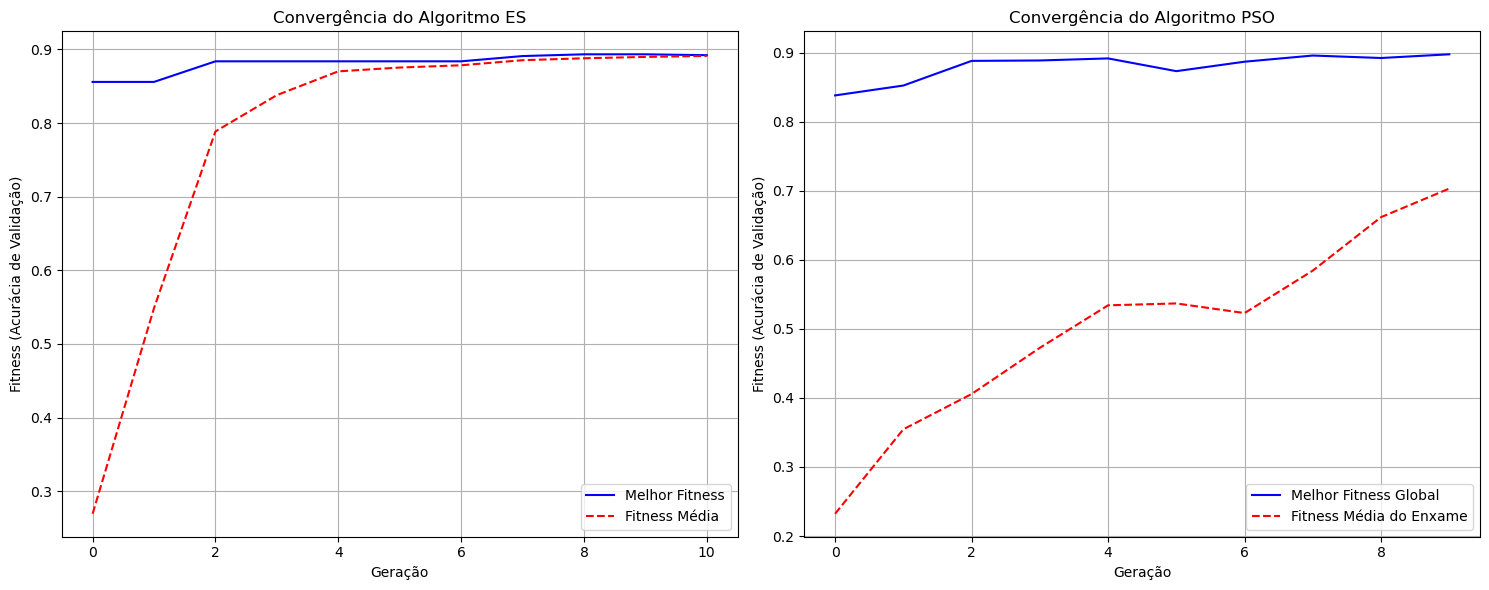

In [16]:
# --- Gráficos de Convergência ---

plt.figure(figsize=(15, 6))

# Gráfico para Estratégia Evolutiva (ES)
ax1 = plt.subplot(1, 2, 1)
gen_es = logbook_es.select("gen")
max_fitness_es = logbook_es.select("max")
avg_fitness_es = logbook_es.select("avg")
ax1.plot(gen_es, max_fitness_es, "b-", label="Melhor Fitness")
ax1.plot(gen_es, avg_fitness_es, "r--", label="Fitness Média")
ax1.set_xlabel("Geração")
ax1.set_ylabel("Fitness (Acurácia de Validação)")
ax1.set_title("Convergência do Algoritmo ES")
ax1.legend(loc="lower right")
ax1.grid(True)

# Gráfico para Particle Swarm Optimization (PSO)
ax2 = plt.subplot(1, 2, 2)
gen_pso = logbook_pso.select("gen")
max_fitness_pso = logbook_pso.select("max")
avg_fitness_pso = logbook_pso.select("avg")
ax2.plot(gen_pso, max_fitness_pso, "b-", label="Melhor Fitness Global")
ax2.plot(gen_pso, avg_fitness_pso, "r--", label="Fitness Média do Enxame")
ax2.set_xlabel("Geração")
ax2.set_ylabel("Fitness (Acurácia de Validação)")
ax2.set_title("Convergência do Algoritmo PSO")
ax2.legend(loc="lower right")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [17]:
# --- Tabela de Resultados Finais ---
results_paper = [
    {"Algorithm": "Adam (Artigo)", "Accuracy": 0.9777, "Precision": np.nan, "Recall": np.nan, "F1-Score": np.nan, "Training Time (s)": 34.77},
    {"Algorithm": "GA (Artigo)", "Accuracy": 0.9885, "Precision": np.nan, "Recall": np.nan, "F1-Score": np.nan, "Training Time (s)": 35.44},
]

#  2. AGRUPAR OS RESULTADOS GERADOS PELO SEU CÓDIGO
my_results = [results_es, results_pso]

# 3. CRIAR O DATAFRAME COMPLETO
df_results = pd.DataFrame(results_paper + my_results)
df_results = df_results.set_index("Algorithm")


print("\n--- Tabela Comparativa de Resultados Finais ---")
display(df_results.style.format({
    "Accuracy": "{:.4f}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1-Score": "{:.4f}",
    "Training Time (s)": "{:.2f}"
}, na_rep="-").background_gradient(cmap='viridis', subset=['Accuracy', 'F1-Score']))


# 5. MELHORAR A EXIBIÇÃO FINAL DOS HIPERPARÂMETROS
print("\nMelhores Hiperparâmetros Encontrados:")
print(f"  - ES:  {results_es['Best Hyperparameters']}")
print(f"  - PSO: {results_pso['Best Hyperparameters']}")


--- Tabela Comparativa de Resultados Finais ---


,Accuracy,Precision,Recall,F1-Score,Training Time (s),Best Hyperparameters
Algorithm,,,,,,
Adam (Artigo),0.9777,-,-,-,34.77,-
GA (Artigo),0.9885,-,-,-,35.44,-
Evolution Strategy (ES),0.9090,0.9085,0.9090,0.9087,218.49,"{'encoder_layers': (204,), 'learning_rate': 0.006694553682255939}"
Particle Swarm (PSO),0.9096,0.9093,0.9096,0.9094,313.69,"{'encoder_layers': (184, 93, 145), 'learning_rate': 0.0024858052505084115}"



Melhores Hiperparâmetros Encontrados:
  - ES:  {'encoder_layers': (204,), 'learning_rate': 0.006694553682255939}
  - PSO: {'encoder_layers': (184, 93, 145), 'learning_rate': 0.0024858052505084115}
